In [1]:
%run ./src.ipynb

2025-04-11 20:21:43.064280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-11 20:21:43.077954: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-11 20:21:43.081908: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


382, 48, 61, participants in Train, Validation, and Test sets
Processing fold 1...
Class weights:  {0: 0.5504628439187452, 1: 5.454140127388535}
Epoch 1/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - AUC: 0.5000 - accuracy: 0.5608 - loss: 3.6640 - val_AUC: 0.7220 - val_accuracy: 0.7199 - val_loss: 2.9556 - learning_rate: 2.0000e-04
Epoch 2/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - AUC: 0.5467 - accuracy: 0.5302 - loss: 3.0580 - val_AUC: 0.7457 - val_accuracy: 0.7820 - val_loss: 2.7806 - learning_rate: 2.0000e-04
Epoch 3/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - AUC: 0.5911 - accuracy: 0.5571 - loss: 2.8447 - val_AUC: 0.7850 - val_accuracy: 0.6729 - val_loss: 2.5974 - learning_rate: 2.0000e-04
Epoch 4/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - AUC: 0.6759 - accuracy: 0.6107 - loss: 2.6472 - val_AUC: 0.8447 - val_accuracy: 0.7801 - val_loss: 2.2767 - learning_rate: 2.0000e-04
Epoch 5/60
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - AUC: 0.7945 - accuracy: 0.6870 - loss: 

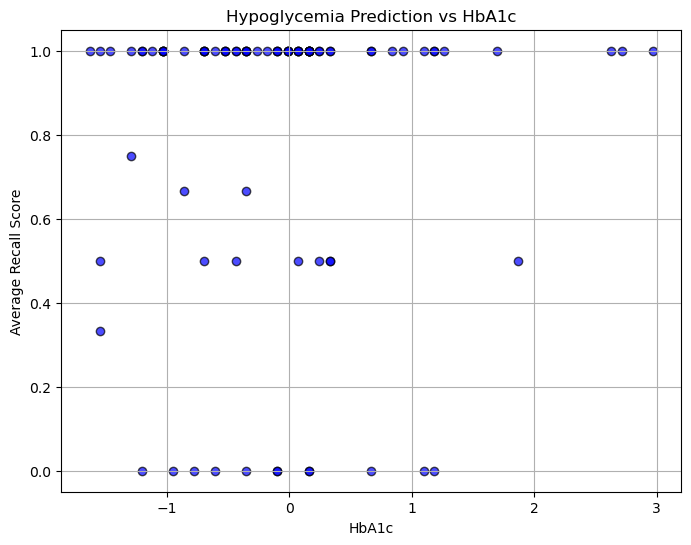

Plot saved at: /home/ma98/results/holdoutResultsFull/EarlyNight2/loss_auc_accuracy_plot.png


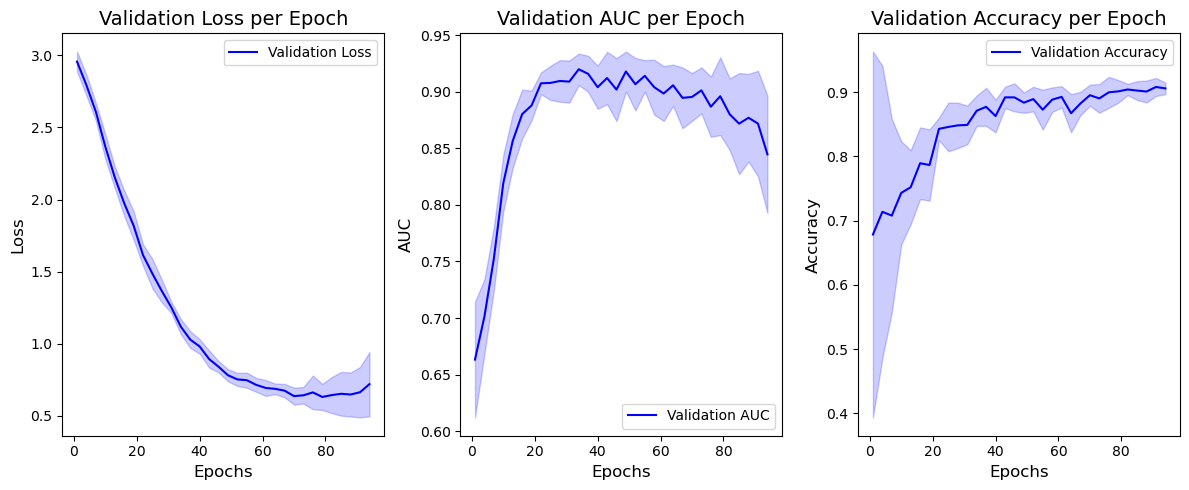

In [5]:
# learning_rate=2e-4
# Resampled
# checkpoint
# monitor='val_loss'
# 10 split
# batch 32

%matplotlib inline

matrix_shape0 = 288
dailyshape = 327
individualshape = 324
folder_name = "/home/__/results/holdoutResultsFull/EarlyNight"

configure_gpu()

# Perform K-Fold Cross-Validation with Transfer Learning
source_results, target_results = cross_validation_holdout_analysis(label_name="hypo_early_night",num_splits=10, num_epochs=60,batch_s=32, num_patience=20, monitored='val_loss',threshold=0.25)

gc.collect()
# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/EarlyNight/source_results.npy"
np.save(saved_results, source_results)
# Save results for comparison
saved_results = "/home/__/results/holdoutResultsFull/EarlyNight/target_results.npy"
np.save(saved_results, target_results)

